#Machine Learning Estadístico para Interfaces Cerebro-Computadora

## Trabajo Práctico de Laboratorio de Computación III - Parte I: introducción al aprendizaje maquinal


❗Antes de comenzar recordá hacer una copia de este documento de manera que puedas editarlo y guardar los cambios en tu Drive.

Este TPLC tiene como objetivo que el alumno sea capaz de:
1. Afianzar los conocimientos sobre análisis discriminante lineal como método de reducción de características y de clasificación
2. Comprender las diferencias entre las diferentes métricas de performance y su correcta utilización según el problema en cuestión.
3. Comprender cómo validar un modelo correctamente

Es **requisito** para aprobar este curso que esta guía práctica sea completada y enviada para su evaluación. Se aceptan trabajos realizados en forma grupal de *hasta dos alumnos por grupo*.

In [ ]:
# instalamos MNE
!pip install MNE

In [ ]:
# Importamos las bibliotecas y funciones
import numpy as np
import matplotlib.pyplot as plt
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne import Epochs, pick_types, events_from_annotations
import mne

La biblioteca más relevante para todo lo que es machine learning es [sckit-learn](https://scikit-learn.org/stable/). En ella encontraremos muchísimas funciones que nos permitirán desde utilizar variados y diferentes métodos de machine learning, hasta particionar nuestros datos y evaluar la performance de nuestros modelos.

La podemos impotar como



```
# import sklearn
```

pero no es deseado cuando sólo se quieren utilizar algunas de las funciones de la librería.

Vamos de a poco ... 😺

## Análisis discriminante lineal


Dado un conjunto de datos $\mathbf{X}$, cuyos vectores filas $\mathbf{x}_n \in \mathbb{R}^{p}$ pertenencen a una y sólo una de las posibles $C$ clases contenidas en el vector de etiquetas $\mathbf{y}\in \mathbb{R}^{N_t}$, buscamos encontrar una proyección que permita maximizar la separabilidad entre las clases. En otras palabras, búscamos que la disperción de los datos sean muy grande entre clases pero muy chiquita intra clases.  

**Definimos**:

Matriz de covarianza intra-clases: $		\displaystyle \hat{\mathbf{S}}_w= \frac{1}{N}\sum_{c=1}^C \sum_{i \in I_c} (\mathbf{x}_i-\boldsymbol{\mu}_c)(\mathbf{x}_i-\boldsymbol{\mu}_c)^T,$

Matriz de covarianza entre-clases:
$\displaystyle\hat{\mathbf{S}}_b= \sum_{c=1}^C N_c(\boldsymbol{\mu}_c-\boldsymbol{\mu})(\boldsymbol{\mu}_c-\boldsymbol{\mu})^T,$

Matriz de covarianza total:
$\hat{\boldsymbol{S}}_t= \mathbf{S}_b + \mathbf{S}_w = \sum_{i=1}^{N} (\mathbf{x}_i - \boldsymbol{\mu})(\mathbf{x}_i - \boldsymbol{\mu})^{T}$

El LDA es un método muy utilizado en el contexto de BCI, pues acompañado de un potente extrator de características, su simpleza y capacidad de otorgar buenos resultados con datos de no gran tamaño, lo vuelve muy atractivo para implementaciones de la vida real en BCI.

## Los datos

Seguimos con el problema de detectar imaginería motora. Vamos a utilizar datos del sujeto 1 en las rondas de MI de pies vs. manos de la base de datos publicada en [1].

In [ ]:
from mne.datasets import eegbci
event_id = dict(hands=2, feet=3)  # MI: hands vs feet runs
# for a given subject
subject = 1

runs = [6, 10, 14]  # motor imagery: hands vs feet runs

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)

Un pipeline clásico para decodificar MI es utilizar señales de 2 segundos de duración, luego de 0.5 segundos de aplicado el estímulo, filtradas entre 8 y 30 Hz, utilizando CSP para extraer 6 features.

Pero antes de cualquier cosa, recordá que debemos particionar nuestros datos en entrenamiento y testeo. En lo que sigue vamos a extraer los trials de señales filtradas y dividir los datos en datos de train y datos de test 👇

In [ ]:
# before epoching, apply a filter!
# Apply band-pass filter to cover the alpha and beta band
raw.filter(8.0, 30.0, fir_design="firwin", skip_by_annotation="edge")
# select the epoch time
tmin, tmax = 0.5, 2.5
events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))
# T1:hands, T2:feet

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude="bads")
# get the epoch object
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)

In [ ]:
# Get data and labels
labels = epochs.events[:, -1]
data = epochs.get_data()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

### LDA como método de reducción de la dimensionalidad

La función [`LinearDiscriminantAnalysis`](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn-discriminant-analysis-lineardiscriminantanalysis) de sklearn tiene implementado el método LDA. Como ya hemos hecho, primero miremos los parámetros que espera esta función

In [ ]:
# import from sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
vars(LinearDiscriminantAnalysis())

❓ ¿Por qué este método también tiene como parámetro `n_components`?


...


#### Manos a la obra 🤝

Vamos a querer replicar el pipeline tradicinal de CSP + LDA. Ayudanos 🙂

1. Ajustá una método CSP tal que sea capaz de extraer 6 features discriminativas

In [ ]:
# escribí tú código acá

2. Calcula las features para los datos de entrenamiento (`X_train_csp`) y testeo (`X_test_csp`)

In [ ]:
# escribí tú código acá

3. Ajustá un modelo LDA utilizando las features CSP. Indicá que el solver de LDA sea mediante descomposición en autovalores. Pensá, qué valor debe tomar el parámetro `n_components`?

In [ ]:
# escribí tú código acá

4. Transformá las features CSP de los datos de entrenamiento al espacio de LDA. Llamá a esas features transformadas como `X_train_lda`. ¿Cuál es el tamaño de `X_train_lda`? ¿Por qué?

💡 TIP: Podes utilizar el método `transform` de lda

In [ ]:
# escribí tú código acá

5. Observá el siguiente código y su correspondiente gráfica. Respondé: ¿qué efecto tiene LDA sobre las features aprendidas por CSP?

In [ ]:
plt.scatter(X_train_lda[y_train==3, 0], X_train_lda[y_train==3,0], s=40, color='blue', label='Hands MI')
plt.scatter(X_train_lda[y_train==2, 0], X_train_lda[y_train==2,0], s=40, color='red', label = 'Feet MI')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.legend()

❓ ¿Cómo podremos hacer para que autumáticamente el algoritmo nos indique que trials pertenencen a una u otra clase? ¿Qué alguna relación entre la posición de las features transformadas y el signo?

.....

### LDA en clasificación

Los métodos de clasificación lineal son denominados de esa forma debido a que la región o frontera de decisión entre un categoría y la otra es lineal.

Cuando trabajamos en un problema de dos clases, LDA en particular proyecta los datos en $C-1$ dimensiones, permitiendo luego con un hyperplano de separación distinguir entre las clases.

Cuando se trabaja con dos clases la región de decisión es una recta, y la categoría de un dato está dada por el signo que tome ese dato transformado en el espacio de LDA.

Para comprender mejor todo esto, vamos a tomar el gráfico anterior y agregarle la recta de decisión.

En sklearn, los coeficientes del clasificador ($W_{LDA}$) pueden extraerse del objeto entrenado mediante el atributo `coef_`. Mira 👇

In [ ]:
Wlda = lda.coef_

❓ ¿Qué tamaño tiene `Wlda` ?

In [ ]:
# escribí tú código acá

Como estamos hablando de hyperplanos, o rectas de decisión no necesariamente afines (que pasen por cero), los clasificadores lineales suelen tener un término de intersect o término independiente que le da ciertos grados de libertad

In [ ]:
w0 = lda.intercept_
print(w0)

Ahora, apliquemos estos coeficientes a mis datos:



In [ ]:
w0 + np.dot(X_train_csp, Wlda.T)

❓ ¿Qué observas? ¿Los datos transformados en el espacio LDA, cömo pueden agruparse como de una u otra clase?

...

## Métricas de performance

Cuando trabajamos en problemas de deteccion e identificación de clases, es muy importante poder cuantificar cuán bien hizo la tarea mi modelo de ML.

Esto es igualmente importante para las BCIs. Pero no todas las métricas son igualmente relevantes para todos los problemas de detección. En este apartado vamos a estudiar algunas de ellas y su aplicación a problemas de BCI

🏃 Pero aaaantes, ¿Cómo accedo a las predicciones en mi clasificador?

💡 Existen dos predicciones relevantes: i) la categoría asignada (clase) y ii) la probabilidad de pertenecer a tal o cuál clase. En sklearn, podemos acceder a ambas predicciones muy sencillamente mediante los método `predict` y `predict_proba`

Estas predicciones pueden observarse mirando los datos de entrenamiento y de testeo. Inspeccioná cómo son las clases asignadas en cada caso y la probabilidad asociada 👇

❓ ¿Qué predicción es más relevante de prestar atención?

In [ ]:
# escribí tú código acá

### Matrices de confusión

Una de las formas de mostrar los resultados de clasificación es mediante una matriz de confusión, que para el caso binario es simplemente:

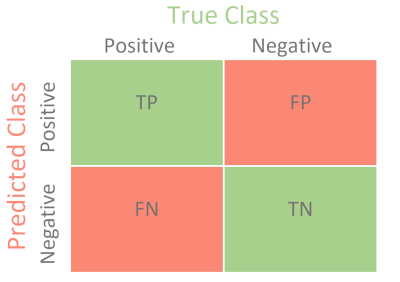

🙆 Para que no te aburras, te vamos a pedir que implementes tu propia función de matriz de confusión, tal que dada la etiqueta real y la predicha, te devuelva un arreglo de 2x2 con la cantidad de TP, FP, FN Y TN.

Una vez programada, utilizá dicha función en las predicciones de testeo encontradas en el punto anterior.

In [ ]:
def matriz_confusion(y_pred, y_real):
    c = np.unique(y_real).shape[0]
    M = np.zeros([c,c])

    tp = 0
    tn = 0
    fn = 0
    fp = 0

    for i in range(0, len(y_real)):
        #completá acá

    M[0,0] = tp
    M[1,1] = tn
    M[0,1] = fp
    M[1,0] = fn

    return M



In [ ]:
M = matriz_confusion(y_pred_test, y_test)
print(M)

### Aciertos, precisión, sensibilidad

Bueno, muy lindo todo, pero ¿cómo anda nuestro pipeline de CSP+LDA?

Ahora que tenemos la matriz de confusión, podemos calcular métricas a partir de los TP, TN, FP y FN. Te animás 👇

In [ ]:
# escribí tú código acá

Por si te lo preguntabas, claro que sí, sklearn trae las implementaciones de estas métricas. Podes chusmear [precision_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html), [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html), [recall_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) 😜

### Indices de desempeño basados en probabilidad

Como vimos, las decisiones de clasificación se basan en un umbral de decisión. Las salidas reales de los clasificadores son probabilidades a posteriori dada por los datos. Para evaluar la funcionalidad de un clasificador en todos sus puntos de decisión, se suelen construir las curcas ROC y calcular el área bajo las mismas.

Recordá que en sklearn las salidas como probabilidades las obtenemos mediante `.predic_proba`.

Miremos la salida del siguiente código..

In [ ]:
umbrales = np.linspace(0,1,100)

tpr = []
fpr = []

for j in range(len(umbrales)):
    y_thresh = y_pred_test_proba[:,1] > umbrales[j]
    M = matriz_confusion(y_thresh, target_test)

    tpr.append(M[0,0] / np.sum(M[:,0]))
    fpr.append(M[0,1] / np.sum(M[:,1]))

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False positive ratio")
plt.ylabel("True positive ratio")

from sklearn.metrics import auc
print('Area bajo la curva', auc(fpr, tpr))

❓ ¿Cómo puedo cuantificar en un único valor lo que observamos en la gráfica?

Para responder a esta pregunta fijate cómo usar la función [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) de sklearn


In [ ]:
# escribí tú código acá

### Clases desbalanceadas

### Problema coloquial

Los algoritmos de aprendizaje maquinal aprenden sus modelos predictivos de un conjunto de
datos de entrenamiento. Dicho datos de entrenamiento, puede presentar un desbalance de clase,
habiendo entonces más observaciones que pertenecen a una clase en particular. En las BCIs,
el paradigma de ERP (P300) es bien conocido por ser una problema de clasificación binario
pero sumamente desbalanceado. En particular la relación 'ConP300' vs. 'SinP300' es 1:5. Una
investigadora está interesada en conocer el impacto de este desbalance para un clasificador en
particular cuando su desempe~no es evaluado utilizando diferentes métricas. Para ello realiza un
experimento utilizando el mismo clasificador entrenados en dos diferentes configuraciones. En la
primera no tiene falsos negativos pero sí falsos positivos, mientras que en la segunda el número de
falsos negativos es 30. La investigadora evalúa ambos clasificadores con la misma base de datos
utilizando una distribución de datos balanceada y la original (desbalanceada). Los resultados
arrojados por cada clasificador para datos balanceados (1:1) y desbalanceados (1:5) se muestra
en la siguiente figura:

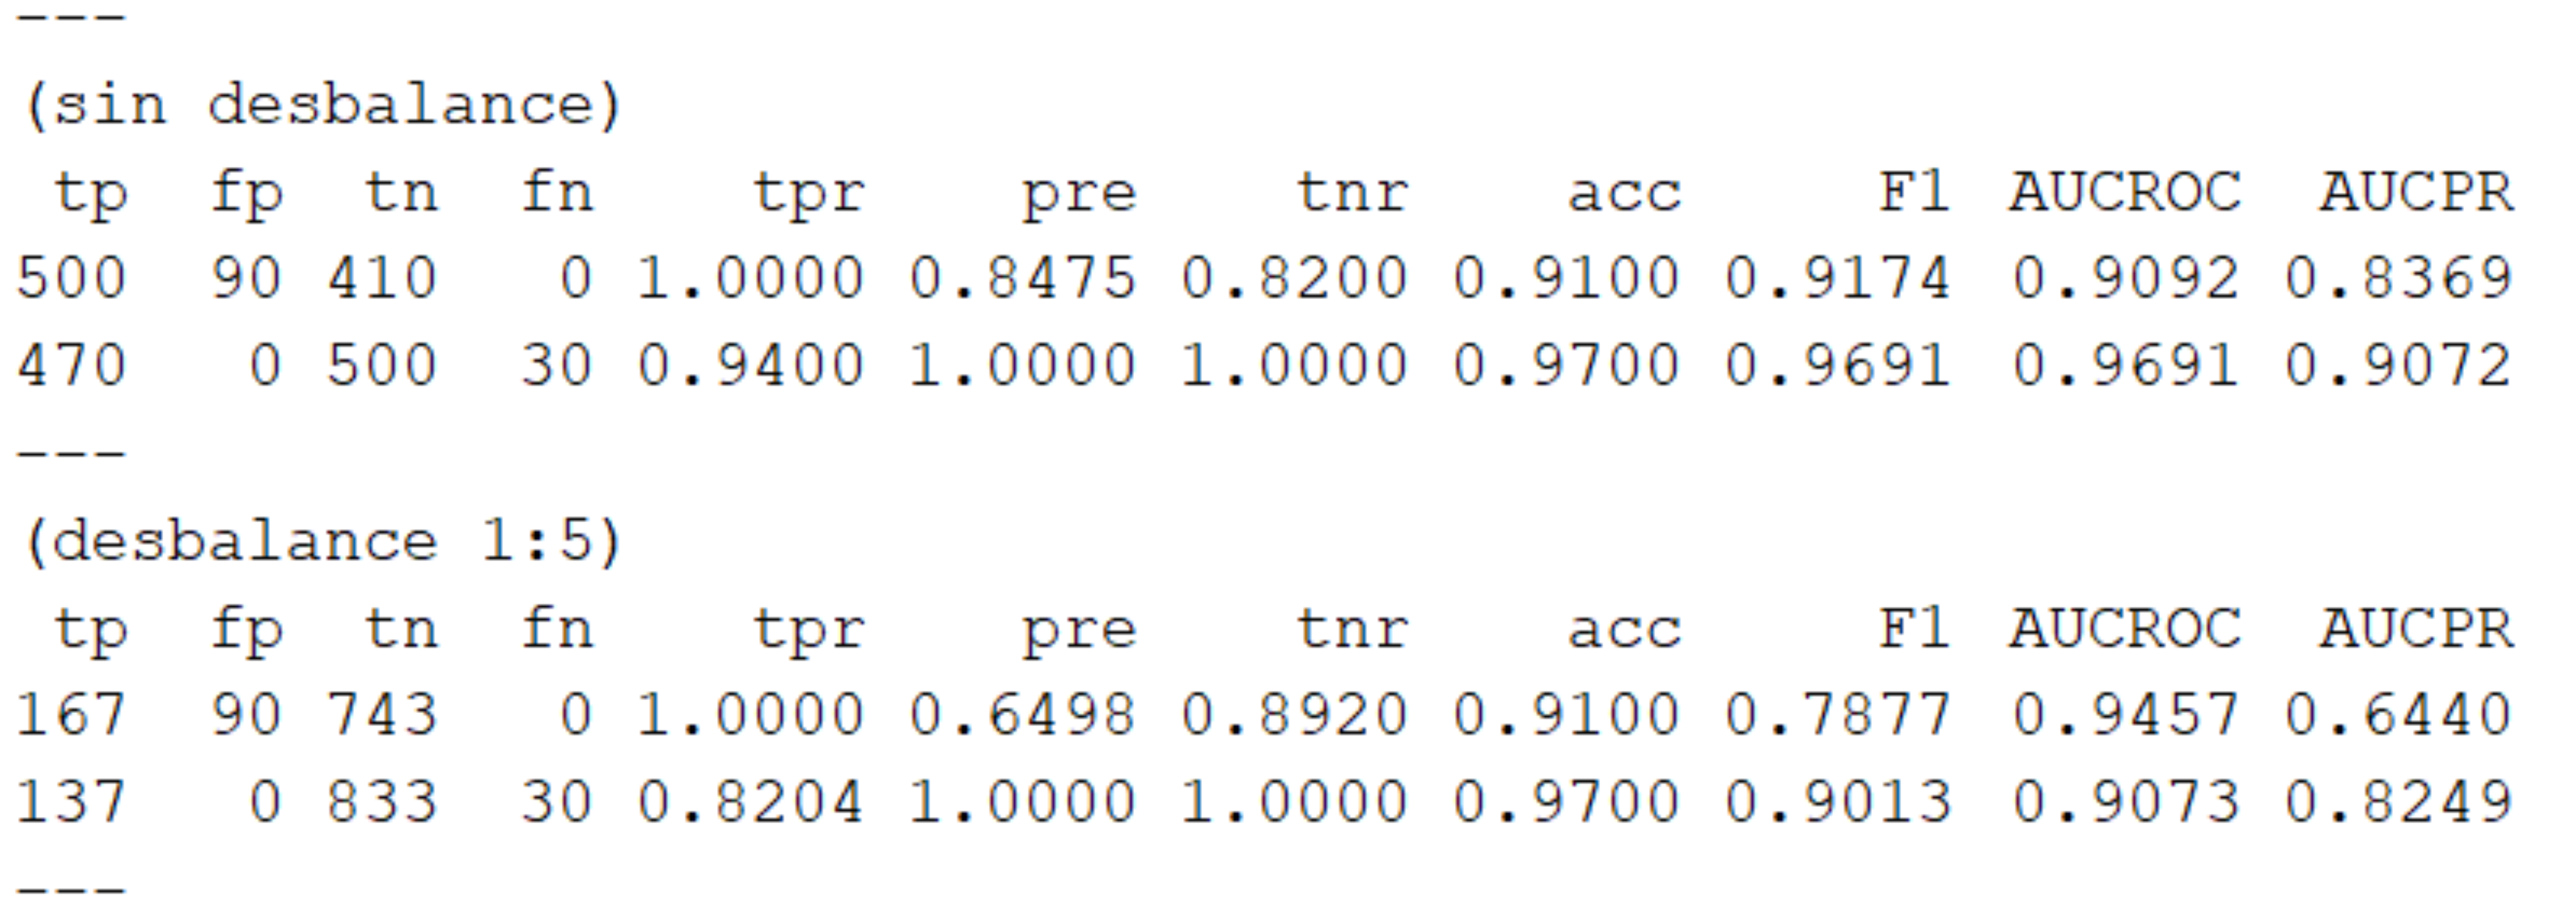

TP: verdaderos positivos, FP: falsos positivos, TN: verdaderos negativos, FN: falsos negativos, TPR: true positive rate, PRE: precisión, TNR: true negative rate, F1: F1-score, AUCROC: área bajo la curva ROC, AUCPR: área bajo la curva PR.

Siendo el $F1-score = \frac{TP}{TP + 0.5(FP+FN)}$

😲

Al analizar estos resultados, la investigadora se encuentra un poco confundida y no sabe cuál es la **mejor medida para reportar los resultados de clasificación**. ¿Vos qué pensas al respecto? Indicá cuáles medidas Uutilizarías y cuáles no considerarías para este análisis. Justificá su respuesta.

.....

## Partición de datos

Particionar los datos una única vez y reportar ese único resultado proocaría que cualquier análisis sobre esos resultados estén sesgados y con mucha incertidumbre. Pues, una única partición podría provocar que justo por el propio azar, los datos de entrenamiento hayan sido muy poco representativos del problema en cuestión y, en consecuencia, la predicción arrojada en los datos de testeo sea incorrecta.

Para dismiuir el sesgo de la predicción, suele repetirse varias veces el proceso de partición de datos, dandonos como lo que se conoce como "validación cruzada"

Existen diferentes formas de implementar esta validación cruzada. Dos de ellas, importantes para este curso, involucran si los datos se muestrean de manera al azar y sin order aparente, y si los datos se muestran respetando la proporción de datos existentes de cada clase

La pregunta que surge es, ¿cómo impactan en BCI las diferentes formas de realizar la validación cruzada? Vamos a explorarlo 🔍

Te vamos a pedir que realices el siguiente experimento 👇

Para el pipeline CSP+LDA, ajustá un modelo para cuando los datos se particionan mediante:

 i) CV1: cross-validación de 5 particiones con sampleo aleatorio sin preservación de orden
 ii) CV2: cross-validación de 5 particiones con sampleo aleatorio con preservación de orden   
 iii) CV3: cross-validación de 5 particiones con sampleo aleatorio con preservación de orden y estratificación.


Utilizá como métrica de performance `roc_auc_score` y fijá la semilla para todos los casos en 42.

💡 TIPS: chusmeá cómo implementar esto mirando a las funciones [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) y [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

In [ ]:
# escribí tú código acá

❓ ¿Qué observaste? ¿Cuál te parece que es la forma de debemos particionar los datos en BCI?

## Para seguir pensando....

❓


1. Si tengo un problema de 4 clases en 2 dimensionales, ¿cuántas rectas de decisión necesito para separar las clases una con respecto a las otras?
2. Si LDA es un método que depende de la estimación de las matrices de covarianza de los datos. ¿Mejorará su predicción si se aumenta la cantidad de datos durante el entrenamiento?
3. Supongamos que tenemos un problema de clasificación desbalanceado, como el problema de detección de P300, en el cuál cada 5 trials sinP300 hay 1 trial con P300. ¿Cómo debo particionar los datos? ¿Será necesario balancear los datos de entrenamiento? ¿y los de testeo?




1 ...

2 ...

3 ...

# References
[1] Blankertz, B., Tomioka, R., Lemm, S., Kawanabe, M., & Muller, K. R. (2007). Optimizing spatial filters for robust EEG single-trial analysis. IEEE Signal processing magazine, 25(1), 41-56.